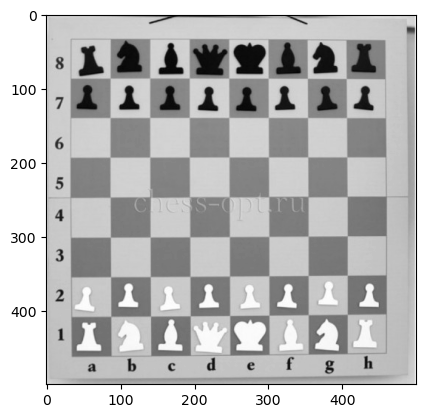

In [8]:
import numpy as np
import cv2
from collections import Counter
import matplotlib.pyplot as plt


path = 'img_1.jpg'
image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

image = image.astype(np.float32)
np.savetxt('img.txt', image, fmt="%d")
plt.imshow(image, cmap='gray')

In [9]:
def haar_transform(img):
    h, w = img.shape
    temp = np.zeros_like(image, dtype=np.float32)
    for i in range(h):
        for j in range(0, w, 2):
            if j + 1 < w:
                # for low frequences
                temp[i, j // 2] = (image[i, j] + image[i, j + 1]) / 2
                # for high frequences
                temp[i, j // 2 + w // 2] = (image[i, j] - image[i, j + 1]) / 2

    result = np.zeros_like(temp, dtype=np.float32)
    for j in range(w):
        for i in range(0, h, 2):
            if i + 1 < h:
                # LL
                result[i // 2, j] = (temp[i, j] + temp[i + 1, j]) / 2
                # HL
                result[i // 2 + h // 2, j] = (temp[i, j] - temp[i + 1, j]) / 2

    ll = result[:h // 2, :w // 2]
    hl = result[h // 2:, :w // 2]
    lh = result[:h // 2, w // 2:]
    hh = result[h // 2:, w // 2:]
    return ll, lh, hl, hh

In [10]:
def quantize(coeffs, n_quants):
    min_val = np.min(coeffs)
    max_val = np.max(coeffs)
    step = (max_val - min_val) / n_quants
    quantized = np.round((coeffs - min_val) / step).astype(int)
    return quantized, min_val, step

In [11]:
def run_length_encode(data):
    encoded = []
    for value, count in Counter(data.flatten()).items():
        encoded.append((value, count))
    return encoded

In [13]:
ll, lh, hl, hh = haar_transform(image)
n_quants = 4

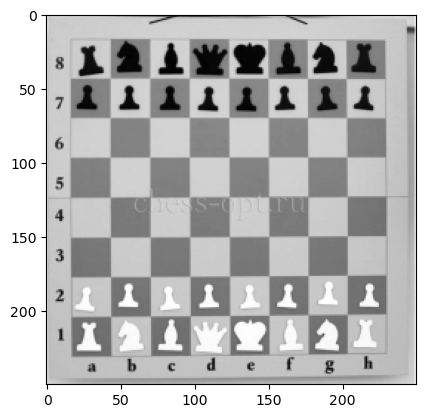

In [14]:
plt.imshow(ll, cmap='gray')

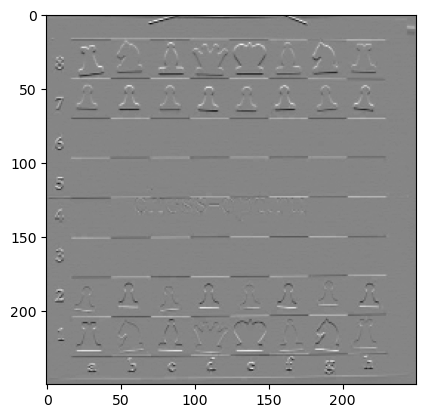

In [15]:
plt.imshow(hl, cmap='gray')

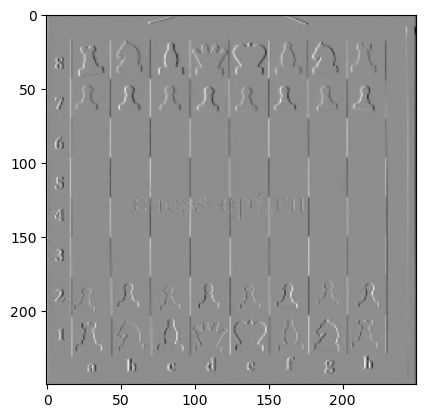

In [16]:
plt.imshow(lh, cmap='gray')

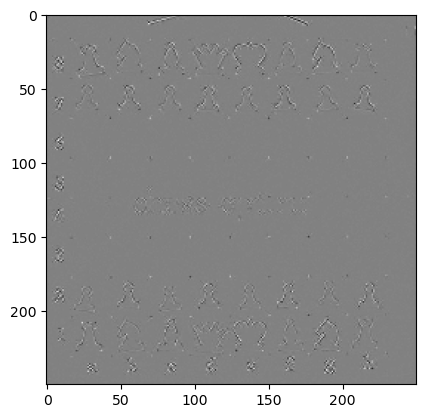

In [17]:
plt.imshow(hh, cmap='gray')

In [19]:
lh_q, lh_min, lh_step = quantize(lh, n_quants)
hl_q, hl_min, hl_step = quantize(hl, n_quants)
hh_q, hh_min, hh_step = quantize(hh, n_quants)

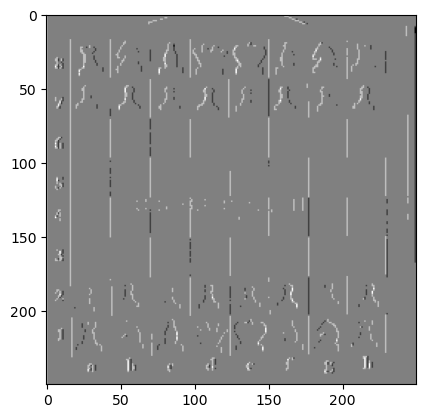

In [20]:
plt.imshow(lh_q, cmap='gray')

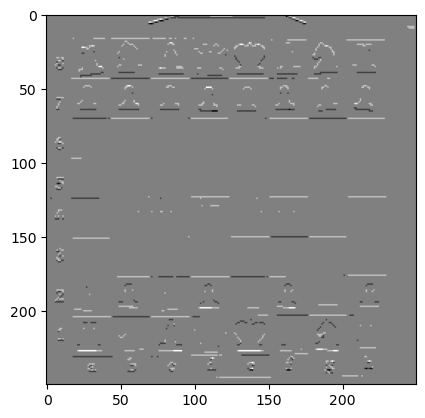

In [21]:
plt.imshow(hl_q, cmap='gray')

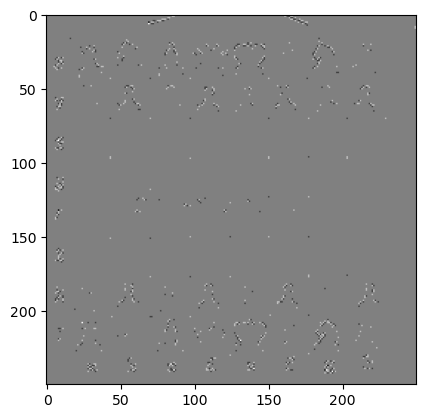

In [22]:
plt.imshow(hh_q, cmap='gray')

In [23]:
lh_rle = run_length_encode(lh_q)
hl_rle = run_length_encode(hl_q)
hh_rle = run_length_encode(hh_q)

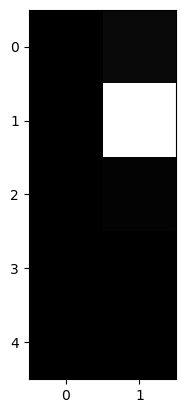

In [24]:
plt.imshow(lh_rle, cmap='gray')

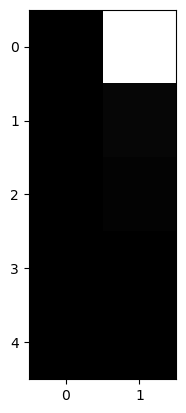

In [25]:
plt.imshow(hl_rle, cmap='gray')

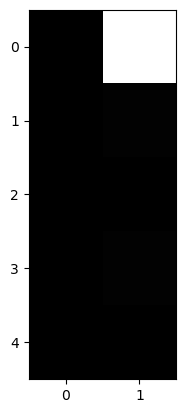

In [26]:
plt.imshow(hh_rle, cmap='gray')

In [32]:
with open('wavelet_data.txt', 'w') as f:
    np.savetxt(f, ll, fmt='%d')
    f.write('\n')
    for value, count in lh_rle:
        f.write(f"{value} {count}\n")
    f.write('\n')
    for value, count in hl_rle:
        f.write(f"{value} {count}\n")
    f.write('\n')
    for value, count in hh_rle:
        f.write(f"{value} {count}\n")

In [33]:
original_size = image.nbytes
compressed_size = 0
with open('wavelet_data.txt', 'r') as f:
    compressed_size = len(f.read().encode('utf-8'))

print(f"original: {original_size} bytes")
print(f"compressed: {compressed_size} bytes")
print(f"compress ratio: {original_size / compressed_size:.2f}")

original: 1000000 bytes
compressed: 246598 bytes
compress ratio: 4.06
